## Extracting Google Pay Transactions from HTML

This script uses the `BeautifulSoup` library to extract transaction data from a Google Pay HTML statement. It reads the HTML file, parses the content, and then extracts relevant transaction information. The extracted data is then stored in a pandas DataFrame, which can be exported to a CSV file for further analysis.

### Steps:
1. Parse the HTML file using BeautifulSoup.
2. Extract transaction details from specific HTML elements.
3. Store the extracted data in a pandas DataFrame.
4. Export the DataFrame to a CSV file for further use.

In [0]:
# from bs4 import BeautifulSoup
# import pandas as pd


# def extract_gpay_transactions(html_path):
#     with open(html_path, "r", encoding="utf-8") as file:
#         soup = BeautifulSoup(file, "html.parser")

#     transactions = []  # Initialize an empty list to store transactions

#     # Find all transaction divs
#     for cell in soup.find_all("div", class_="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1"):
#         text = cell.get_text(separator=" ").strip()  # Ensure correct spacing
            
#         transactions.append(text)

#     # Convert to DataFrame
#     df = pd.DataFrame(transactions, columns=["text"])

 

#     return df


# df_gpay = extract_gpay_transactions("/FileStore/tables/gpay_statement.html")
# df_gpay.to_csv('gpay_statement.csv')
# print(df_gpay.head(15))


## Reading and Processing Google Pay Transactions from CSV with PySpark

This script demonstrates how to load a CSV file containing Google Pay transaction data into a PySpark DataFrame. The data is processed by applying a regular expression transformation to anonymize certain parts of the text (such as replacing part of the bank account number with `XXXXXXX`).

### Steps:
1. Load the CSV file into a PySpark DataFrame with the specified file options (header, delimiter).
2. Apply a transformation to replace occurrences of the string `'9999'` in the `text` column with `'XXXXXXX'` using `regexp_replace`.
3. Display the resulting DataFrame.

In [0]:
from pyspark.sql import functions as F, types as T
# File location and type
file_location = "/FileStore/tables/gpay_statement-1.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df = df.withColumn(
    'text', 
    F.regexp_replace('text', '9999', 'XXXXXXX')
)


df.head(10)

Out[5]: [Row(_c0='0', text='Received ₹66.00 Jan 25, 2025, 7:07:50\u202fPM GMT+05:30'),
 Row(_c0='1', text='Received ₹400.00 Jan 25, 2025, 6:09:04\u202fPM GMT+05:30'),
 Row(_c0='2', text='Paid ₹61.00 to ISHAQ FILLING STATIO using Bank Account XXXXXXXX1661 Jan 24, 2025, 7:29:42\u202fPM GMT+05:30'),
 Row(_c0='3', text='Paid ₹40.00 to Mr Varaganti Santhosh Kumar using Bank Account XXXXXXXX1661 Jan 24, 2025, 7:11:37\u202fPM GMT+05:30'),
 Row(_c0='4', text='Paid ₹129.00 to Tobox Ventures Private Limited using Bank Account XXXXXXXX1661 Jan 24, 2025, 12:53:45\u202fPM GMT+05:30'),
 Row(_c0='5', text='Paid ₹450.00 to Zerodha Broking Ltd using Bank Account XXXXXXXX1661 Jan 24, 2025, 10:27:10\u202fAM GMT+05:30'),
 Row(_c0='6', text='Paid ₹20.00 to NATTE SATYAPRASAD using Bank Account XXXXXXXX1661 Jan 24, 2025, 9:23:53\u202fAM GMT+05:30'),
 Row(_c0='7', text='Paid ₹1800.00 to MR.DURGUM PUDI RAMA KRISHNA REDDY   using Bank Account XXXXXXXX1661 Jan 23, 2025, 10:01:53\u202fPM GMT+05:30'),
 Row(_c0='8'

## Google Pay Transaction Data Processing in PySpark

This document outlines the process of extracting and transforming Google Pay transaction data using PySpark. The process includes data extraction, cleaning, and conversion of timestamps to a desired format.

### Steps Involved:

1. **Receiver Extraction:**
   - The `receiver` column is extracted using a regular expression to capture the recipient's name following the pattern `to {name} using`.


In [0]:
df = df.withColumn('receiver', F.regexp_extract('text', r'to\s(.+?)\susing', 1))

2. Price Extraction:

The price column is extracted using a regular expression to match the currency value (₹ symbol followed by the amount). and also converting it into double format

In [0]:
df = df.withColumn('price', F.regexp_extract('text', r'₹(\d+\.\d{2})', 1))
df = df.withColumn("price", F.col("price").cast("double"))

3. Text Cleaning:

The text column is cleaned by replacing multiple spaces with a single space using regexp_replace.
The transaction_type column is extracted by splitting the text column and taking the first word (e.g., "Paid" or "Sent").

In [0]:
df = df.withColumn("text", F.regexp_replace(F.col("text"), r'\s+', ' '))
df = df.withColumn(
    'transaction_type', F.split(F.col('text'),' ').getItem(0)
)

4. Timestamp Extraction:

The time_stamp column is extracted using a regular expression matching the timestamp format: MMM dd, yyyy, h:mm:ss a.

In [0]:
from datetime import datetime

df = df.withColumn(
    'time_stamp',
    F.regexp_extract(
        'text', r'\w{3} \d{1,2}, \d{4}, \d{1,2}:\d{2}:\d{2}.{3}', 0)
)

# Custom function to convert date format
def convert_date_format(date_str):
    try:
        # Convert from "MMM dd, yyyy, h:mm:ss a" to datetime object
        date_obj = datetime.strptime(date_str, "%b %d, %Y, %I:%M:%S %p")
        # Convert to desired format "dd-MM-yy HH:mm:ss"
        return date_obj.strftime("%d-%m-%y %H:%M:%S")
    except Exception as e:
        return None

# Register the UDF
convert_date_udf = F.udf(convert_date_format, T.StringType())

# Sample DataFrame with the original timestamp
# data = [("Jan 25, 2025, 7:07:50 PM",), ("Feb 14, 2024, 11:30:45 AM",)]
# pdf = spark.createDataFrame(data, ["time_stamp"])

# Apply the UDF to convert the timestamp
df = df.withColumn("time_stamp", convert_date_udf(F.col("time_stamp")))

df = df.withColumn(
    "time_stamp",
    F.to_timestamp(F.col("time_stamp"), "dd-MM-yy HH:mm:ss")
)

# Show the DataFrame with the converted timestamp
df.head(10)


Out[9]: [Row(_c0='0', text='Received ₹66.00 Jan 25, 2025, 7:07:50\u202fPM GMT+05:30', receiver='', price=66.0, transaction_type='Received', time_stamp=datetime.datetime(2025, 1, 25, 19, 7, 50)),
 Row(_c0='1', text='Received ₹400.00 Jan 25, 2025, 6:09:04\u202fPM GMT+05:30', receiver='', price=400.0, transaction_type='Received', time_stamp=datetime.datetime(2025, 1, 25, 18, 9, 4)),
 Row(_c0='2', text='Paid ₹61.00 to ISHAQ FILLING STATIO using Bank Account XXXXXXXX1661 Jan 24, 2025, 7:29:42\u202fPM GMT+05:30', receiver='ISHAQ FILLING STATIO', price=61.0, transaction_type='Paid', time_stamp=datetime.datetime(2025, 1, 24, 19, 29, 42)),
 Row(_c0='3', text='Paid ₹40.00 to Mr Varaganti Santhosh Kumar using Bank Account XXXXXXXX1661 Jan 24, 2025, 7:11:37\u202fPM GMT+05:30', receiver='Mr Varaganti Santhosh Kumar', price=40.0, transaction_type='Paid', time_stamp=datetime.datetime(2025, 1, 24, 19, 11, 37)),
 Row(_c0='4', text='Paid ₹129.00 to Tobox Ventures Private Limited using Bank Account XXXXX

Classifying Transactions by Receiver

This step groups the data by the reciever column and counts the number of transactions (represented by price) for each receiver. The result is stored in a new column called classifying that indicates the number of transactions associated with each receiver.

In [0]:
df.groupBy('receiver').agg(F.count('price').alias('classifying')).display()

receiver,classifying
NASER KHAN,1
Amazon Pay,27
Slns Nanakramguda Fuels,1
BANDHI KANAKARAJ,1
Om Sree Nava Durga Petroleums,1
VIJETHA SUPERMARKETS PVT LTD,1
LENSKART,1
KOLA VENKANNA,3
TOBOX VENTURES PRIVA,1
K Vishnu,1


I have done enough with data cleaning stuff.. Now comes classifying them


In near future I will make use of this

# Installing NLTK (Natural Language Toolkit)

To work with natural language processing tasks, you need to install the **NLTK** library, which provides tools for text processing, tokenization, stemming, tagging, parsing, and more.

In [0]:
# !pip install nltk

### Categorizing Transactions Based on Descriptions in PySpark

In this example, we categorize transaction descriptions into predefined categories using a custom function and PySpark's User Defined Functions (UDF). The categorization function is based on a set of keywords for each category.

#### Steps:

1. **Import Required Modules**:
   - Import necessary PySpark functions: `from pyspark.sql import functions as F`.
   - Import the required data type `StringType` for the UDF: `from pyspark.sql.types import StringType`.

2. **Define the Categorization Function**:
   - A Python function `categorize_transaction` is defined to categorize transaction descriptions based on keywords.
   - A dictionary `categories` holds the category names as keys, with a list of keywords related to each category.
   - The function checks if any keyword is present in the description (converted to lowercase). If a match is found, it returns the corresponding category.

3. **Example Categories and Keywords**:
   - **Food & Dining**: restaurant, biryani, pizza, swiggy, zomato, etc.
   - **Groceries**: supermarket, kirana, bigbasket, etc.
   - **Fuel & Transport**: petrol, fuel, station, metro, etc.
   - **Investment**: zerodha, insurance, loan, etc.
   - **Shopping & Retail**: amazon, flipkart, myntra, etc.
   - **Health & Medical**, **Entertainment**, **Bills & Utilities**, etc.

4. **Apply the Categorization Function**:
   - We use a **User Defined Function (UDF)** to apply the categorization function across a DataFrame column.
   - The UDF `categorize_udf` is registered and applied to the `reciever` column to create a new `Category` column.

5. **Output**:
   - The DataFrame is updated with a new column `Category` that contains the corresponding category for each transaction description.


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# Define the categorization function
def categorize_transaction(description):
    # if description.isEmpty():
    #     return "self"
    categories = {
    "Food & Dining": [
        "restaurant", "biryani", "pizza", "swiggy", "zomato", "cafe", "hotel", "food", "meals", 
        "bakery", "burger", "frankie", "tobox", "ventures", "eats", "coffee", "cakes", 
        "new balaji mithai bhandar", "bbinstant", "bakers", "veg", "nonveg", "res", "jumbo", 
        "taco", "mithai", "kitchen", "yummy", "chocolate", "tiffin", "bake", "green juice& potato twister",
        "pista house", "new dolphin"
    ],
    "Groceries": [
        "supermarket", "kirana", "bigbasket", "bazaar", "store", "mart", "vegetables", "groceries", 
        "zepto"
    ],
    "Fuel & Transport": [
        "petrol", "fuel", "filling", "metro", "station", "bp", "oil", "transport", "l&t metro", 
        "toll", "park hyderabad", "ride", "auto"
    ],
    "Investment": [
        "zerodha broking ltd", "investment", "insurance", "loan", "zerodha", "groww", "property", "broker"
    ],
    "Shopping & Retail": [
        "amazon", "flipkart", "myntra", "lenskart", "ikea", "store", "shop", "bazaar", "brand", "traders"
    ],
    "Home": [
        "thota gopal", "homeo"
    ],
    "Health & Medical": [
        "pharmacy", "medplus", "medical", "apollo", "clinic", "hospital"
    ],
    "Entertainment": [
        "movie", "pvr", "inox", "bookmyshow", "netflix", "prime", "play"
    ],
    "Bills & Utilities": [
        "recharge", "electricity", "water", "bill", "payment", "prepaid"
    ]
    }



    description = str(description).lower()  # Ensure it's a string
    for category, keywords in categories.items():
        if any(keyword in description for keyword in keywords):
            return category
    return "Other"

# Register UDF in PySpark
categorize_udf = F.udf(categorize_transaction, StringType())

df = df.withColumn("Category", categorize_udf(F.col("receiver")))

# Show the DataFrame with the new Category column
df.show(truncate=False)


+---+--------------------------------------------------------------------------------------------------------------------------+----------------------------------------+------+----------------+-------------------+----------------+
|_c0|text                                                                                                                      |receiver                                |price |transaction_type|time_stamp         |Category        |
+---+--------------------------------------------------------------------------------------------------------------------------+----------------------------------------+------+----------------+-------------------+----------------+
|0  |Received ₹66.00 Jan 25, 2025, 7:07:50 PM GMT+05:30                                                                        |                                        |66.0  |Received        |2025-01-25 19:07:50|Other           |
|1  |Received ₹400.00 Jan 25, 2025, 6:09:04 PM GMT+05:30                    

### Filtering and Displaying Distinct Receivers for 'Paid' Transactions in the 'Other' Category

This code filters the transactions where the transaction type is 'Paid' and the category is 'Other'. It then selects and displays distinct receivers (recipients) involved in these transactions.


In [0]:
df.filter(
    (df.transaction_type == 'Paid')& (df.Category == 'Other')
).select("receiver").distinct().display()

receiver
NASER KHAN
BANDHI KANAKARAJ
KOLA VENKANNA
K Vishnu
KAVALE SANJU KUMAR
AENKARLA VARA LAXMI
THONTA NAVEEN
ASHOK RAM
CHOTU RAM
MR.DURGUM PUDI RAMA KRISHNA REDDY


### Filtering and Displaying Distinct Receivers for 'Paid' Transactions in the 'Other' Category

This code filters the transactions where the transaction type is 'Paid' and the category is 'Other'. It then selects and displays distinct receivers (recipients) involved in these transactions.


In [0]:
df.filter(F.col("Category") == "Other") \
  .groupBy('receiver') \
  .agg(F.count('price').alias('classifying')) \
  .orderBy(F.col('classifying').desc()) \
  .show(truncate=True)


+--------------------+-----------+
|            receiver|classifying|
+--------------------+-----------+
|                    |        401|
|        THOTA  GOPAL|         30|
|Mr Varaganti Sant...|          8|
|GUMMADAVELLI  SRI...|          7|
|AENKARLA  VARA LAXMI|          4|
|             G PANDU|          4|
| Chanagala Swarupini|          4|
|      KOLA  VENKANNA|          3|
|      THONTA  NAVEEN|          3|
|    ATTAVELLI SWATHI|          3|
|Bommagouni Baraddwaj|          2|
|Bundl Technologie...|          2|
|        D RAMAMURTHY|          2|
|BATHINA VEERA VEN...|          2|
|     Sunitha Sankhla|          2|
|   NANDHI KESAVAN  M|          2|
|LINGAMPALLY SRISAILA|          2|
|         PRAMOD SAIN|          2|
|    Vasamsetti Srinu|          2|
|             Raidurg|          2|
+--------------------+-----------+
only showing top 20 rows



In [0]:
# pip install matplotlib

### Visualizing Google Pay Monthly Spending Trend

In this section, we filter the data for transactions labeled as 'Paid' and 'Sent', then group the transactions by month to calculate the total spending. The Spark DataFrame is then converted to a Pandas DataFrame, and we plot the data to visualize the trend of monthly expenses.


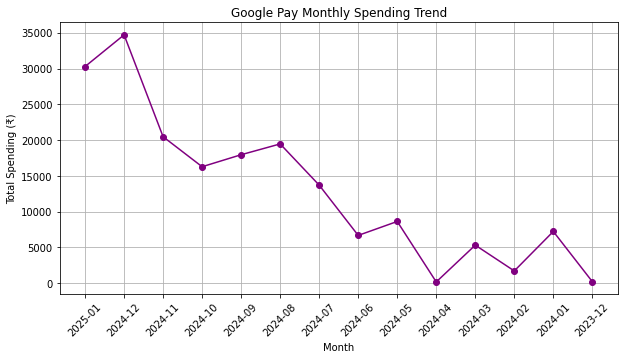

In [0]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
df_gpay = df.filter(((F.col('transaction_type') == 'Paid')| (F.col('transaction_type')== 'Sent')))
# Group by Month and calculate total spending
df_gpay = df_gpay.withColumn("Month", F.date_format("time_stamp", "yyyy-MM"))
monthly_expenses = df_gpay.groupBy("Month").agg(F.sum("price").alias("total_spending")).orderBy(df_gpay.Month.desc())

# Convert the Spark DataFrame to Pandas DataFrame for plotting
monthly_expenses_pandas = monthly_expenses.toPandas()

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(monthly_expenses_pandas["Month"], monthly_expenses_pandas["total_spending"], marker='o', color="purple")
plt.xlabel("Month")
plt.ylabel("Total Spending (₹)")
plt.title("Google Pay Monthly Spending Trend")
plt.grid()
plt.xticks(rotation=45)  # Rotate month labels for better readability
plt.show()


In [0]:
monthly_expenses.orderBy(df_gpay.Month.desc()).display()
df_gpay.display()

Month,total_spending
2025-01,30279.0
2024-12,34707.33
2024-11,20468.509999999995
2024-10,16279.619999999999
2024-09,17956.989999999998
2024-08,19466.179999999997
2024-07,13707.0
2024-06,6683.0
2024-05,8630.0
2024-04,180.0


_c0,text,receiver,price,transaction_type,time_stamp,Category,Month
2,"Paid ₹61.00 to ISHAQ FILLING STATIO using Bank Account XXXXXXXX1661 Jan 24, 2025, 7:29:42 PM GMT+05:30",ISHAQ FILLING STATIO,61.0,Paid,2025-01-24T19:29:42.000+0000,Fuel & Transport,2025-01
3,"Paid ₹40.00 to Mr Varaganti Santhosh Kumar using Bank Account XXXXXXXX1661 Jan 24, 2025, 7:11:37 PM GMT+05:30",Mr Varaganti Santhosh Kumar,40.0,Paid,2025-01-24T19:11:37.000+0000,Other,2025-01
4,"Paid ₹129.00 to Tobox Ventures Private Limited using Bank Account XXXXXXXX1661 Jan 24, 2025, 12:53:45 PM GMT+05:30",Tobox Ventures Private Limited,129.0,Paid,2025-01-24T12:53:45.000+0000,Food & Dining,2025-01
5,"Paid ₹450.00 to Zerodha Broking Ltd using Bank Account XXXXXXXX1661 Jan 24, 2025, 10:27:10 AM GMT+05:30",Zerodha Broking Ltd,450.0,Paid,2025-01-24T10:27:10.000+0000,Investment,2025-01
6,"Paid ₹20.00 to NATTE SATYAPRASAD using Bank Account XXXXXXXX1661 Jan 24, 2025, 9:23:53 AM GMT+05:30",NATTE SATYAPRASAD,20.0,Paid,2025-01-24T09:23:53.000+0000,Other,2025-01
7,"Paid ₹1800.00 to MR.DURGUM PUDI RAMA KRISHNA REDDY using Bank Account XXXXXXXX1661 Jan 23, 2025, 10:01:53 PM GMT+05:30",MR.DURGUM PUDI RAMA KRISHNA REDDY,1800.0,Paid,2025-01-23T22:01:53.000+0000,Other,2025-01
9,"Paid ₹248.00 to ISHAQ FILLING STATIO using Bank Account XXXXXXXX1661 Jan 20, 2025, 8:38:03 PM GMT+05:30",ISHAQ FILLING STATIO,248.0,Paid,2025-01-20T20:38:03.000+0000,Fuel & Transport,2025-01
10,"Paid ₹10.00 to THOTA GOPAL using Bank Account XXXXXXXX1661 Jan 20, 2025, 8:22:03 PM GMT+05:30",THOTA GOPAL,10.0,Paid,2025-01-20T20:22:03.000+0000,Other,2025-01
11,"Paid ₹10.00 to THOTA GOPAL Jan 20, 2025, 8:21:57 PM GMT+05:30",,10.0,Paid,2025-01-20T20:21:57.000+0000,Other,2025-01
12,"Paid ₹30.00 to Mr Varaganti Santhosh Kumar using Bank Account XXXXXXXX1661 Jan 20, 2025, 7:58:05 PM GMT+05:30",Mr Varaganti Santhosh Kumar,30.0,Paid,2025-01-20T19:58:05.000+0000,Other,2025-01


This code filters the Google Pay transactions DataFrame to exclude transactions of type 'Received' and only considers transactions that occurred after December 31, 2024 this 'year'. It then groups the data by 'receiver' and 'Category', calculates the total price (sum) for each group, and filters for transactions under the "Other" category. Finally, it displays the results.


In [0]:
df_pandas = df_gpay.filter((F.col('transaction_type') != 'Received')& (F.col('time_stamp') >= '2024-12-31'))
df_pandas.groupBy('receiver', 'Category').agg(F.sum('price')).filter((F.col("Category") == "Other")).display()

receiver,Category,sum(price)
SHAIKH M JAVED,Other,650.0
KEMPAWANAIYA NM,Other,210.0
NASER KHAN,Other,300.0
,Other,9985.0
Bollepally Ravikumar,Other,130.0
SREENU CHEEKATI,Other,20.0
APP KA BAZAR,Other,460.0
NATTE SATYAPRASAD,Other,20.0
Addanki Balathripura Easwar,Other,278.0
SRI DURGA,Other,500.0


# Google Pay Expense Breakdown Visualization

This analysis provides insights into the total spending across various categories based on Google Pay transaction data. We visualize the breakdown using two types of charts:

## 1. Pie Chart
The pie chart shows the percentage breakdown of total spending across categories, making it easy to see which categories contribute the most.

## 2. Bar Chart
The bar chart represents the total spending in each category, offering a clear comparison of the amounts spent across categories.

The data used for these charts is filtered to include transactions from December 2024 onwards and includes only 'Paid' and 'Sent' transactions.

## Steps:
- Data is first filtered by transaction type and date.
- Total spending is calculated for each category.
- Two visualizations are generated:
  - **Pie Chart**: Displaying the percentage of spending per category.
  - **Bar Chart**: Displaying the total spending per category.
  
Both charts are customized for clear readability and effective comparison of spending trends across categories.



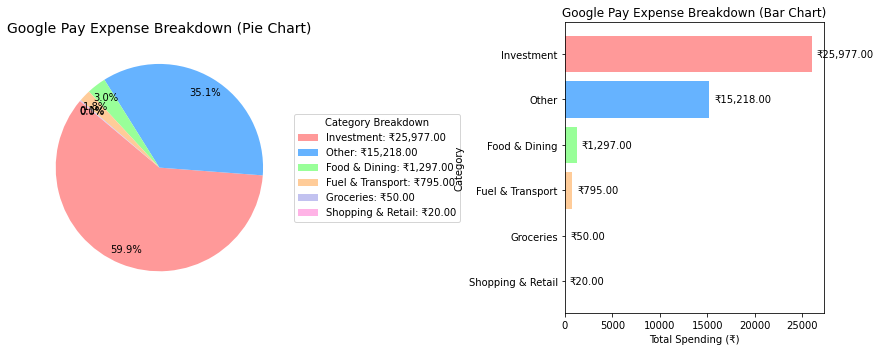

In [0]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
df_pandas = df_gpay.filter((F.col('time_stamp') >= '2024-12-31') & ((F.col('transaction_type') == 'Paid')| (F.col('transaction_type')== 'Sent'))).select("Category", "price").toPandas()

# Group by Category and sum prices
category_totals = df_pandas.groupby("Category")["price"].sum().sort_values(ascending=False)

# Define distinct colors (adjust as needed)
colors = ["#ff9999", "#66b3ff", "#99ff99", "#ffcc99", "#c2c2f0", "#ffb3e6", "#ff6666", "#ffcc66", "#99ccff", "#66ff66"]

# Format labels with category name & total spending
labels = [f"{cat}: ₹{total:,.2f}" for cat, total in zip(category_totals.index, category_totals.values)]

## 🎯 1. PIE CHART
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
wedges, _, autotexts = plt.pie(
    category_totals, 
    labels=None,  # Hide direct labels on the pie
    autopct="%1.1f%%", 
    colors=colors,
    textprops={'fontsize': 10},  # Set font size for percentage text
    startangle=140,  # Rotate for better layout
    pctdistance=0.85  # Push percentage text inside the pie
)
# Add a legend with category totals
plt.legend(wedges, labels, title="Category Breakdown", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)
plt.title("Google Pay Expense Breakdown (Pie Chart)", fontsize=14)

## 🎯 2. BAR CHART
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
bars = plt.barh(category_totals.index, category_totals.values, color=colors[:len(category_totals)])
plt.xlabel("Total Spending (₹)")
plt.ylabel("Category")
plt.title("Google Pay Expense Breakdown (Bar Chart)")

# Add total values on bars
for bar, total in zip(bars, category_totals.values):
    plt.text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2, f"₹{total:,.2f}", va='center', fontsize=10)

plt.gca().invert_yaxis()  # Invert y-axis for better order

## 🎯 SHOW BOTH PLOTS
plt.tight_layout()
plt.show()
